In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## 将数据加载到 DataFrame，并合并

In [3]:
#pd.read_csv('data/ch02/names/yob1880.txt', names=['name', 'sex', 'births'])

years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = '../data/datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)

    frame['year'] = year
    pieces.append(frame)

#  将多个 DataFrame 连接成一个
names = pd.concat(pieces, ignore_index=True)

## 聚合

In [4]:
# 按年度聚合，区分性别
total_births = names.pivot_table('births', index='year',
                                 columns='sex', aggfunc=sum)
total_births.head(10)

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
1885,133056,107802
1886,144538,110785
1887,145983,101412
1888,178631,120857


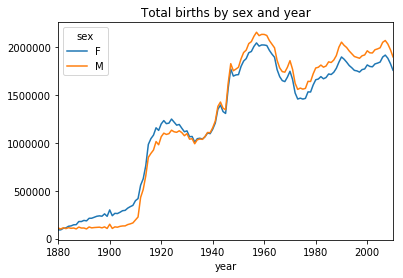

In [5]:
#  画张图看看
total_births.plot(title='Total births by sex and year')

## 数据转换

In [6]:
# 计算名字占所有出生婴儿的比重

def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)

    group['prop'] = births / births.sum()
    return group
names = names.groupby(['year', 'sex']).apply(add_prop)
names.head()

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


In [7]:
# 检查所有分组的 prop 之和是否近似=1
np.allclose(names.groupby(['year','sex']).prop.sum(),1)

True

## 数据筛选

 取 Top1000的名字

In [8]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
top1000.head()

name sex  births  year      prop
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077643
         1       Anna   F    2604  1880  0.028618
         2       Emma   F    2003  1880  0.022013
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188

## 结果展示

### 分析命名趋势

/usr/local/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10d992978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1176ae898>], dtype=object)

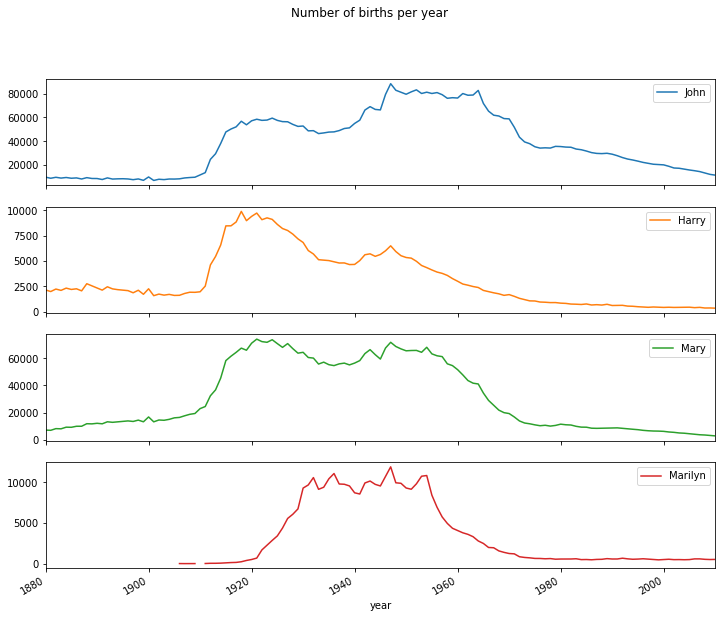

In [9]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

# 按名字聚合，做透视表
total_births = top1000.pivot_table('births', index='year', columns='name',
                                   aggfunc=sum)

# 分析5个名字的趋势
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title="Number of births per year")

### 评估名字的多样性

/usr/local/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
/usr/local/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


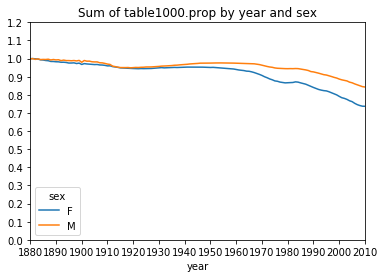

In [10]:
#  最流行的1000个名字的占比
table = top1000.pivot_table('prop', index='year',
                            columns='sex', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

In [11]:
# 占总出生人数前50%的不同名字的数量
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q) + 1  #numpy 的 searchsorted，查找 q 放在哪个索引合适

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)   # 按 year 分组，每个分组都执行一次
diversity = diversity.unstack('sex')  
diversity.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


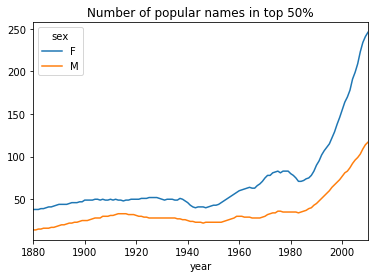

In [12]:
diversity.plot(title="Number of popular names in top 50%")

### 最后一个字母的变革

In [13]:
#  获取尾字母，并聚合
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters,
                          columns=['sex', 'year'], aggfunc=sum)
# 选取有代表性的3个年份
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

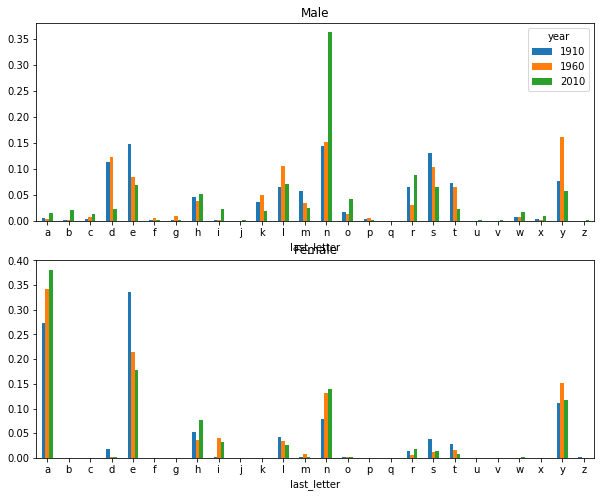

In [14]:
#  规范化处理，计算比例
letter_prop = subtable / subtable.sum().astype(float)

#  绘图
plt.subplots_adjust(hspace=0.25)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female',
                      legend=False)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


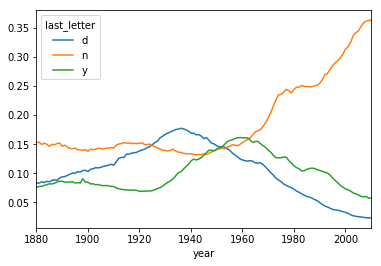

In [15]:
# 进一步分析男孩的 d, n, y 三个字母
letter_prop = table / table.sum().astype(float)

dny_ts = letter_prop.ix[['d', 'n', 'y'], 'M'].T
plt.close('all')
dny_ts.plot()

###  男孩名变成女孩名

In [16]:
# 合并重复的名字
all_names = top1000.name.unique()  

# 找到 lesl 开头的名字
mask = np.array(['lesl' in x.lower() for x in all_names])  
lesley_like = all_names[mask]
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

In [17]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

In [18]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')
table = table.div(table.sum(1), axis=0)
table.tail()

/usr/local/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
/usr/local/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


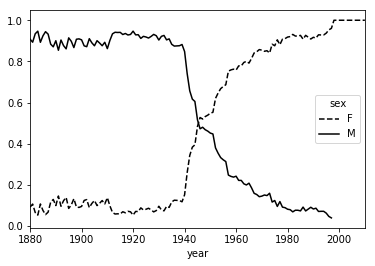

In [19]:
plt.close('all')
table.plot(style={'M': 'k-', 'F': 'k--'})